# Imports

In [37]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing

In [48]:
df = pd.read_csv("output.csv", index_col=0)

In [21]:
df

,binome_statut,binome_date_proposition,binome_date_creation,binome_acceptance_delay,binome_date_update_statut,binome_cancellation_reason,binome_score,field_of_study,study_level,degree,...,registration_date_x,desired_exchange_frequency,hobby,project_confidence_level,project_development_level,registration_date_y,workfield,current_role,needs_to_address,status_flag
binome_id,,,,,,,,,,,,,,,,,,,,,
157657,REJECTED,2024-08-01 14:54:30,NaN,0,2024-08-03 15:00:00,Not specified (or Not provided),7,NaN,NaN,NaN,...,NaN,Not specified (or Not provided),Not specified (or Not provided),3.0,3.0,2024-08-01 00:41:51,"Accounting, management",Senior Expertise Consulting & Auditing,"discover, to apply, motivate, perform",0
157701,REJECTED,2024-08-06 15:36:55,NaN,0,2024-08-08 16:00:00,Not specified (or Not provided),12,NaN,NaN,NaN,...,NaN,Not specified (or Not provided),Not specified (or Not provided),3.0,3.0,2024-08-01 14:40:09,Banking-Finance,Manager - Financial Evaluation,"discover, to apply, perform, english",0
157710,COMPLETED,2024-08-12 15:54:34,2024-08-12 17:51:39,117,2025-05-16 16:19:05,Not applicable,11,NaN,NaN,NaN,...,NaN,Not specified (or Not provided),Not specified (or Not provided),3.0,3.0,2024-08-11 03:17:54,Computer science,Network Engineer,"discover, to apply, motivate, perform, english",1
157715,CANCELLED,2024-08-12 16:54:52,2024-08-13 19:01:38,1566,2024-10-07 15:16:03,No response from the mentee,9,NaN,NaN,NaN,...,NaN,Not specified (or Not provided),Not specified (or Not provided),3.0,3.0,2024-08-08 15:37:28,Marketing-advertising,CRM Animation Manager,to apply,0
157729,REJECTED,2024-08-12 17:16:43,NaN,0,2024-08-14 18:00:02,Not specified (or Not provided),8,"Commerce, Management, Economics, Management",Bac+1,Licence,...,2024-08-06 12:35:07,More than once per week,Not specified (or Not provided),3.0,3.0,2024-08-01 11:53:32,Human Resources,Payroll Manager,"discover, to apply, motivate, perform",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200197,PENDING,2025-07-29 10:52:11,2025-07-29 12:31:59,99,2025-09-12 13:00:02,Not specified (or Not provided),6,"Commerce, Management, Economics, Management",Bac+3,Autre,...,2025-07-26 21:58:14,Not specified (or Not provided),Not specified (or Not provided),3.0,2.0,2025-06-30 19:31:39,Marketing-advertising,NaN,NaN,0
200202,PENDING,2025-07-29 11:03:01,2025-07-29 11:03:48,0,2025-09-12 11:30:03,Not specified (or Not provided),7,"Communication, Marketing, Advertising",Bac+3,Ecole Post-bac,...,2025-07-24 22:41:29,Not specified (or Not provided),Not specified (or Not provided),5.0,4.0,2025-04-18 21:54:50,Marketing-advertising,NaN,NaN,0
200206,CANCELLED,2025-07-29 15:19:19,2025-07-29 15:21:41,2,2025-09-26 12:05:13,No response from either party,7,NaN,NaN,NaN,...,NaN,Not specified (or Not provided),Not specified (or Not provided),3.0,3.0,2025-02-06 13:52:28,"Assistance, Administrative, Reception",Company administrative manager,NaN,0


We transform the column from a string with ',' to several one-hot encoded columns.

In [49]:
column="needs_to_address"

df[column] = (
    df[column]
    .fillna("")                       # Replace NaN with empty string
    .astype(str)                      # Ensure all are strings
    .str.split(",\s*")                # Split by comma and optional spaces
)

mlb = MultiLabelBinarizer()
column_df = mlb.fit_transform(df[column])
df[mlb.classes_] = pd.DataFrame(column_df, columns=mlb.classes_, index=df.index)

df = df.drop(column, axis=1)

We drop columns that are less useful.

In [50]:
df = df.drop(["binome_statut", "binome_date_proposition", "binome_date_creation", "binome_date_update_statut", "binome_cancellation_reason", "registration_date_x", "registration_date_y"], axis=1)

# dropping some columns for saving time
df = df.drop(["current_role", "hobby", "binome_acceptance_delay", "degree", "average_grade", "program", "desired_exchange_frequency", '', 'discover', 'english', 'motivate', 'perform', 'to apply'], axis=1)

In [51]:
# columns_to_fill = ['field_of_study', 'study_level', 'degree', 'needs', 'program']
columns_to_fill = ['field_of_study', 'study_level', 'needs']
df[columns_to_fill] = df[columns_to_fill].fillna("Unknown")

In [8]:
df.columns

Index(['binome_score', 'field_of_study', 'study_level', 'needs',
       'engagement_score', 'project_confidence_level',
       'project_development_level', 'workfield', 'status_flag'],
      dtype='object')

In [52]:
categorical_columns = [i for i in range(df.shape[1]) if i not in {0, 4, 5, 6}]
categorical_columns_names = [df.columns[i] for i in categorical_columns]

In [10]:
# for col in categorical_columns:
#     df[df.columns[col]] = df[df.columns[col]].astype('category').cat.codes

In [27]:
df

,binome_score,field_of_study,study_level,needs,engagement_score,project_confidence_level,project_development_level,workfield,status_flag
binome_id,,,,,,,,,
157657,7,Unknown,Unknown,Unknown,0.0,3.0,3.0,"Accounting, management",0
157701,12,Unknown,Unknown,Unknown,0.0,3.0,3.0,Banking-Finance,0
157710,11,Unknown,Unknown,Unknown,0.0,3.0,3.0,Computer science,1
157715,9,Unknown,Unknown,Unknown,0.0,3.0,3.0,Marketing-advertising,0
157729,8,"Commerce, Management, Economics, Management",Bac+1,[pro],3.0,3.0,3.0,Human Resources,0
...,...,...,...,...,...,...,...,...,...
200197,6,"Commerce, Management, Economics, Management",Bac+3,[pro],-2.0,3.0,2.0,Marketing-advertising,0
200202,7,"Communication, Marketing, Advertising",Bac+3,[pro],3.0,5.0,4.0,Marketing-advertising,0
200206,7,Unknown,Unknown,Unknown,0.0,3.0,3.0,"Assistance, Administrative, Reception",0


# Clustering

We run the elbow method to find the optimal number of clusters on a limited number of samples to save time.

In [12]:
restricted_df = df.sample(2000, random_state=42)

2
5
10
15


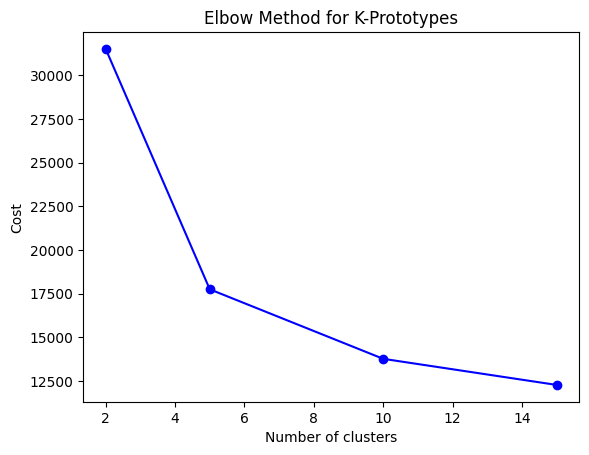

In [13]:
costs = []
K = [2, 5, 10, 15]

for k in K:
    print(k)
    kp = KPrototypes(
        n_clusters=k,
        init='Huang',
        n_init=5,       # reduce number of random initializations (default is 10)
        max_iter=50,   # reduce maximum iterations (default is 100)
        # verbose=1
    )
    kp.fit_predict(restricted_df, categorical=categorical_columns)  # specify categorical columns
    costs.append(kp.cost_)

plt.plot(K, costs, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method for K-Prototypes')
plt.show()

We use 10 clusters in the following.

In [28]:
k=10
kp = KPrototypes(
    n_clusters=k,
    init='Huang',
    n_init=5,       # reduce number of random initializations (default is 10)
    max_iter=50,   # reduce maximum iterations (default is 100)
    verbose=1
)
labels=kp.fit_predict(df, categorical=categorical_columns)  # specify categorical columns

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/50, moves: 3664, ncost: 105184.29436332782
Run: 1, iteration: 2/50, moves: 1477, ncost: 103765.86282918628
Run: 1, iteration: 3/50, moves: 912, ncost: 103261.26016494038
Run: 1, iteration: 4/50, moves: 411, ncost: 103113.58840342108
Run: 1, iteration: 5/50, moves: 442, ncost: 102816.45816408728
Run: 1, iteration: 6/50, moves: 194, ncost: 102781.55392413914
Run: 1, iteration: 7/50, moves: 123, ncost: 102750.14572077073
Run: 1, iteration: 8/50, moves: 92, ncost: 102734.80467102378
Run: 1, iteration: 9/50, moves: 51, ncost: 102730.50698838272
Run: 1, iteration: 10/50, moves: 17, ncost: 102730.13024864817
Run: 1, iteration: 11/50, moves: 0, ncost: 102730.13024864817
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/50, moves: 3615, ncost: 105777.28312631142
Run: 2, iteration: 2/50, moves: 2017, ncost: 103566.81403927662
Run: 2, iteration: 3

In [53]:
df['cluster'] = labels

In [30]:
df['cluster'].value_counts()

cluster
3    2017
2    1933
6    1818
1    1775
9    1539
5    1410
0    1399
4    1352
8     717
7     311
Name: count, dtype: int64

In [34]:
centroids =  kp.cluster_centroids_
centroids_df = pd.DataFrame(centroids, columns=df.columns[:-1])  # exclude 'cluster' column
centroids_df

,binome_score,field_of_study,study_level,needs,engagement_score,project_confidence_level,project_development_level,workfield,status_flag
0,4.795568263045032,-1.1358112937812723,4.163688348820586,3.8248749106504647,"Commerce, Management, Economics, Management",Bac+1,[study],"Trade, distribution",0
1,1.5307042253521126,-2.9729577464788735,3.4580281690140846,2.7847887323943663,"Commerce, Management, Economics, Management",Bac+1,[study],"Coaching, personal development support",0
2,0.6756337299534403,0.026901189860320744,3.3114330056906365,2.9896533885152614,Unknown,Unknown,[study],"Coaching, personal development support",0
3,6.028259791769956,0.22310361923648983,3.24640555280119,2.9791769955379275,Unknown,Unknown,[pro],"Trade, distribution",0
4,3.298076923076923,0.10428994082840237,2.789940828402367,2.283284023668639,Other,Bac+1,[pro],Computer science,0
5,1.1517730496453902,3.1560283687943262,3.4539007092198584,3.00709219858156,Other,Bac+4,[pro],Consulting-Audit,0
6,5.863586358635864,2.9086908690869087,3.511001100110011,3.0346534653465347,"IT, IS, Data, Web, Tech",Bac+4,[pro],Computer science,0
7,1.0932475884244373,9.237942122186496,3.3086816720257235,2.797427652733119,"Commerce, Management, Economics, Management",Bac+4,[pro],Consulting-Audit,0
8,6.072524407252441,8.474198047419804,3.400278940027894,2.899581589958159,"Commerce, Management, Economics, Management",Bac+4,[pro],Computer science,0
9,5.341130604288499,-3.336582196231319,3.400259909031839,2.7296946068875894,"Commerce, Management, Economics, Management",Bac+1,[pro],"Trade, distribution",0


In [98]:
df.groupby('cluster')['status_flag'].mean()

cluster
0    0.199428
1    0.197746
2    0.340404
3    0.311353
4    0.240385
5    0.394326
6    0.350935
7    0.479100
8    0.390516
9    0.152697
Name: status_flag, dtype: float64

In [54]:
df['status_flag'].mean()

0.2872258426178964

# Analysis of the top 3 clusters
We keep clusters 5,7 and 8 that have the highest successful rates of mentor-mentee pairs.

In [ ]:
clusters_top = [5, 7, 8]

In [72]:
for cluster in clusters_top:
    print(cluster, df.loc[df["cluster"]==cluster, "status_flag"].mean())

    for col in df.columns:
        if col in categorical_columns_names:
            print(col, df.loc[df["cluster"]==cluster, col].mode()[0], df[col].mode()[0])
        else:
            print(col, df.loc[df["cluster"]==cluster, col].mean(), df[col].mean())
    print("")

7 0.4790996784565916
binome_score 1.0932475884244373 3.6821526171957117
field_of_study Commerce, Management, Economics, Management Commerce, Management, Economics, Management
study_level Bac+4 Bac+1
needs [pro] [pro]
engagement_score 9.237942122186496 0.5135589657347067
project_confidence_level 3.3086816720257235 3.408100343353654
project_development_level 2.797427652733119 2.948356807511737
workfield Consulting-Audit Trade, distribution
status_flag 0 0
cluster 7.0 3.981641090323033

5 0.3943262411347518
binome_score 1.1517730496453902 3.6821526171957117
field_of_study Other Commerce, Management, Economics, Management
study_level Bac+4 Bac+1
needs [pro] [pro]
engagement_score 3.1560283687943262 0.5135589657347067
project_confidence_level 3.4539007092198584 3.408100343353654
project_development_level 3.00709219858156 2.948356807511737
workfield Consulting-Audit Trade, distribution
status_flag 0 0
cluster 5.0 3.981641090323033

8 0.3905160390516039
binome_score 6.072524407252441 3.682152

In [95]:
# Proportion of pairs represented by our top 3 clusters
df.loc[df["cluster"].isin(clusters_top)].shape[0]/df.shape[0]

0.13544951299838834

/tmp/ipykernel_128170/165768610.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=overall_proportions.index, y=overall_proportions.values, palette='pastel', ax=axes[0])
/tmp/ipykernel_128170/165768610.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_proportions.index, y=cluster_proportions.values, palette='pastel', ax=axes[1])


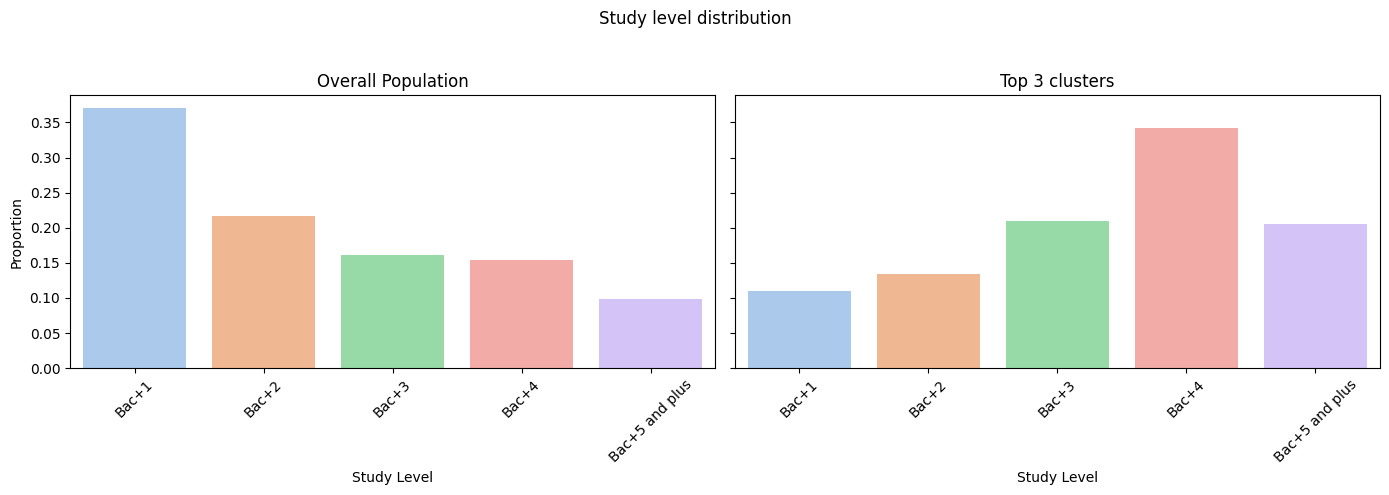

In [96]:
# 1️⃣ Filter out "Not specified (or Not provided)"
df_filtered = df[~df['study_level'].isin(["Not specified (or Not provided)", "Unknown"])]

# 2️⃣ Prepare data for overall population
overall_counts = df_filtered['study_level'].value_counts().sort_index()
overall_proportions = overall_counts / overall_counts.sum()

# 3️⃣ Prepare data for selected clusters
df_clusters = df_filtered[df_filtered['cluster'].isin(clusters_top)]
cluster_counts = df_clusters['study_level'].value_counts().sort_index()
cluster_proportions = cluster_counts / cluster_counts.sum()

# 4️⃣ Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

# Plot overall population
sns.barplot(x=overall_proportions.index, y=overall_proportions.values, palette='pastel', ax=axes[0])
axes[0].set_title('Overall Population')
axes[0].set_ylabel('Proportion')
axes[0].set_xlabel('Study Level')
axes[0].tick_params(axis='x', rotation=45)

# Plot clusters 5,7,8
sns.barplot(x=cluster_proportions.index, y=cluster_proportions.values, palette='pastel', ax=axes[1])
axes[1].set_title('Top 3 clusters')
axes[1].set_ylabel('')
axes[1].set_xlabel('Study Level')
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle('Study level distribution')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


/tmp/ipykernel_128170/711402199.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='engagement_score', data=df_filtered, palette='pastel', ax=axes[0])
/tmp/ipykernel_128170/711402199.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='engagement_score', data=df_clusters, palette='pastel', ax=axes[1])


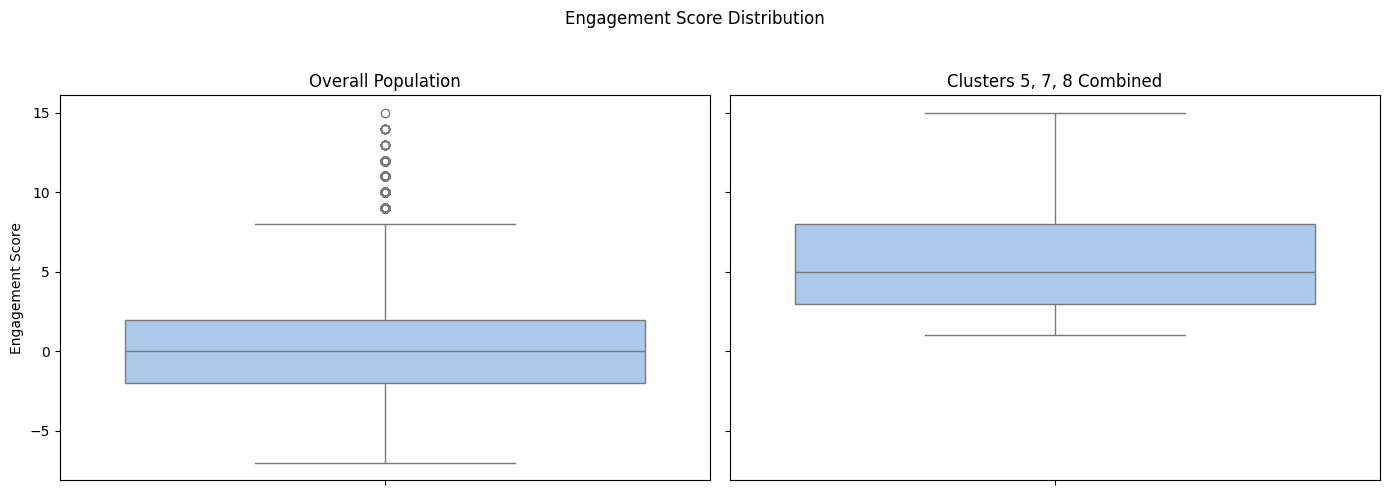

In [85]:
# 1️⃣ Filter out any unwanted rows if necessary
df_filtered = df.dropna(subset=['engagement_score'])  # drop missing values

# 2️⃣ Select clusters of interest
df_clusters = df_filtered[df_filtered['cluster'].isin(clusters_top)]

# 3️⃣ Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14,5), sharey=True)

# Plot overall population
sns.boxplot(y='engagement_score', data=df_filtered, palette='pastel', ax=axes[0])
axes[0].set_title('Overall Population')
axes[0].set_ylabel('Engagement Score')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)

# Plot clusters 5,7,8
sns.boxplot(y='engagement_score', data=df_clusters, palette='pastel', ax=axes[1])
axes[1].set_title('Clusters 5, 7, 8 Combined')
axes[1].set_ylabel('')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle('Engagement Score Distribution')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


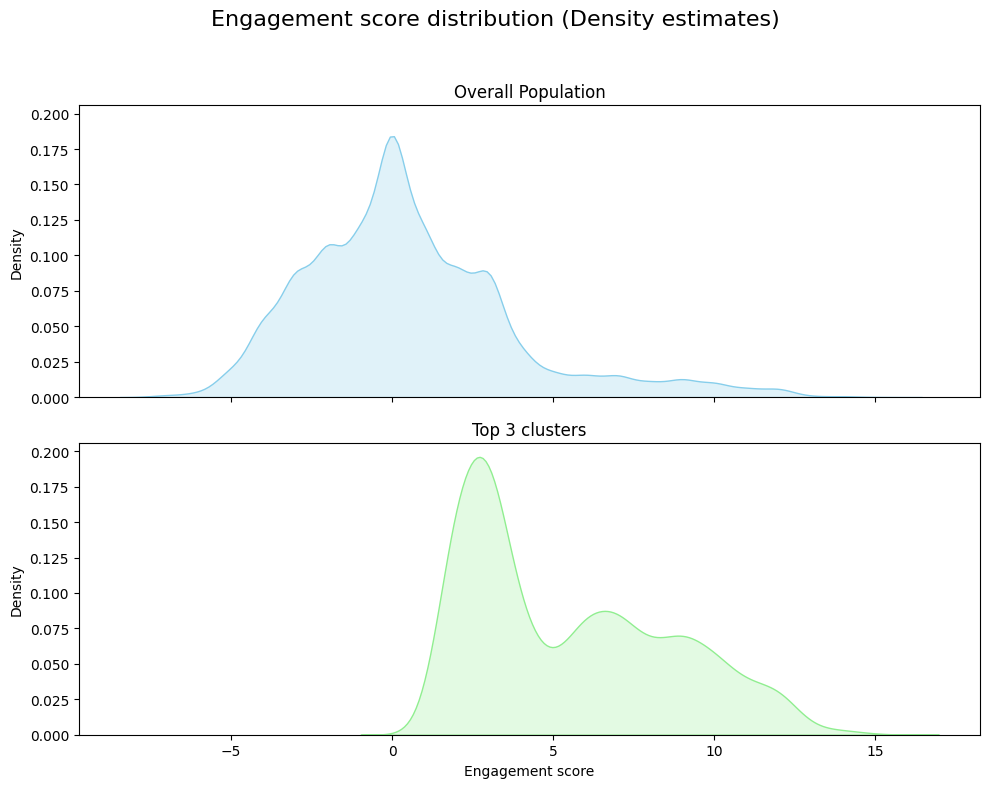

In [97]:
# 1️⃣ Filter missing engagement_score values
df_filtered = df.dropna(subset=['engagement_score'])

# 2️⃣ Select clusters of interest
df_clusters = df_filtered[df_filtered['cluster'].isin(clusters_top)]

# 3️⃣ Create vertical subplots, shared x and y axes
fig, axes = plt.subplots(2, 1, figsize=(10,8), sharex=True, sharey=True)

# Overall population KDE
sns.kdeplot(df_filtered['engagement_score'], fill=True, color='skyblue', ax=axes[0])
axes[0].set_title('Overall Population')
axes[0].set_ylabel('Density')

# Clusters 5,7,8 KDE
sns.kdeplot(df_clusters['engagement_score'], fill=True, color='lightgreen', ax=axes[1])
axes[1].set_title('Top 3 clusters')
axes[1].set_xlabel('Engagement score')
axes[1].set_ylabel('Density')

plt.suptitle('Engagement score distribution (Density estimates)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Analysis of the bottom 3 clusters

In [99]:
clusters_bottom = [0,1,9]

In [100]:
for cluster in clusters_bottom:
    print(cluster, df.loc[df["cluster"]==cluster, "status_flag"].mean())

    for col in df.columns:
        if col in categorical_columns_names:
            print(col, df.loc[df["cluster"]==cluster, col].mode()[0], df[col].mode()[0])
        else:
            print(col, df.loc[df["cluster"]==cluster, col].mean(), df[col].mean())
    print("")

0 0.19942816297355254
binome_score 4.795568263045032 3.6821526171957117
field_of_study Commerce, Management, Economics, Management Commerce, Management, Economics, Management
study_level Bac+1 Bac+1
needs [study] [pro]
engagement_score -1.1358112937812723 0.5135589657347067
project_confidence_level 4.163688348820586 3.408100343353654
project_development_level 3.8248749106504647 2.948356807511737
workfield Trade, distribution Trade, distribution
status_flag 0 0
cluster 0.0 3.981641090323033

1 0.19774647887323943
binome_score 1.5307042253521126 3.6821526171957117
field_of_study Commerce, Management, Economics, Management Commerce, Management, Economics, Management
study_level Bac+1 Bac+1
needs [study] [pro]
engagement_score -2.9729577464788735 0.5135589657347067
project_confidence_level 3.4580281690140846 3.408100343353654
project_development_level 2.7847887323943663 2.948356807511737
workfield Coaching, personal development support Trade, distribution
status_flag 0 0
cluster 1.0 3.9816

In [102]:
# Example setup: list of bottom clusters
target_field = "Commerce, Management, Economics, Management"

# 1️⃣ Compute overall proportion
overall_prop = (df['field_of_study'] == target_field).mean()

# 2️⃣ Compute proportion for bottom clusters
cluster_subset = df[df['cluster'].isin(clusters_bottom)]
cluster_prop = (cluster_subset['field_of_study'] == target_field).mean()

# 3️⃣ Print results
print(f"Overall population proportion of '{target_field}': {overall_prop:.2%}")
print(f"Bottom 3 clusters proportion of '{target_field}': {cluster_prop:.2%}")


Overall population proportion of 'Commerce, Management, Economics, Management': 15.71%
Bottom 3 clusters proportion of 'Commerce, Management, Economics, Management': 22.66%
